<a href="https://colab.research.google.com/github/vishwesh1010/CS_6301-DL_for_NLP-/blob/main/Project/Contextual_Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing various packages and dependency**

In [ ]:
!pip install tokenizers
!pip install transformers
!pip install emoji
!pip install tensorflow-addons
import gc
import os
import emoji as emoji
import seaborn as sns
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel,BertModel, BertTokenizer,AutoTokenizer,TFAutoModelForSequenceClassification,AdamW


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Read Dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: xlabel='class', ylabel='count'>

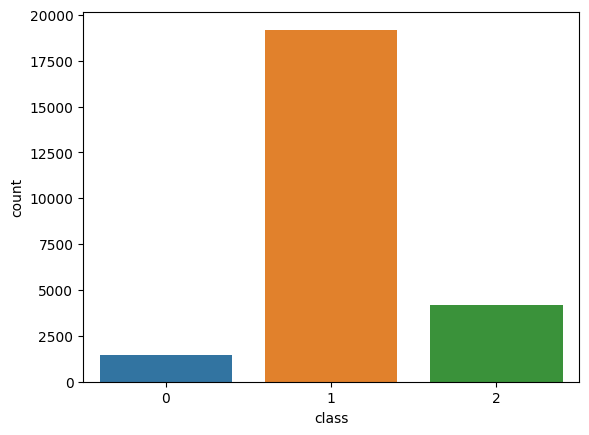

In [ ]:
sns.countplot(x ='class', data = df)

# **Dataset Preprocessing**

In [ ]:
df = df.drop(['count', 'hate_speech', 'offensive_language', 'neither','Unnamed: 0'], axis=1)
   

In [ ]:
def pre_process_tweets(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']
    for value in values:
    # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        for emo in text:
            if emoji.is_emoji(emo):
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")

        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values

In [ ]:
df['tweet'] = pre_process_tweets(df['tweet'].tolist())
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldn t comp...
1,1,rt mleew boy dats coldtyga dwn bad for cuffin...
2,1,rt urkindofbrand dawg rt sbaby life you ever ...
3,1,rt c g anderson viva based she look like a tr...
4,1,rt shenikaroberts the shit you hear about me ...


In [ ]:
data = df['tweet']
labels = df['class']
train_text, temp_text, train_labels, temp_labels = train_test_split(data, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)
print("Train_size:",len(train_text))
print("Val_size:",len(train_text))
print("Test_size:",len(train_text))

Train_size: 19826
Val_size: 19826
Test_size: 19826


# **FineTuning using AutoModel and Pretraining using AutoTokenizer BERT**

Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:

tokenized_train_data = dict(tokenizer(train_text[:].tolist(), padding='max_length', truncation=True))
tokenized_val_data = dict(tokenizer(val_text[:].tolist(), padding='max_length', truncation=True))
tokenized_test_data = dict(tokenizer(test_text[:].tolist(), padding='max_length', truncation=True))

Split Data

In [ ]:
train_set_for_final_model = tf.data.Dataset.from_tensor_slices((tokenized_train_data,tf.keras.utils.to_categorical(train_labels, num_classes=3)))
train_set_for_final_model =train_set_for_final_model.batch(8)
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((tokenized_val_data,tf.keras.utils.to_categorical(val_labels, num_classes=3)))
val_set_for_final_model =val_set_for_final_model.batch(8)
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((tokenized_test_data,tf.keras.utils.to_categorical(test_labels, num_classes=3)))
test_set_for_final_model =test_set_for_final_model.batch(8)

Model

In [ ]:


model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0, name='Recall_0'),tf.keras.metrics.Recall(class_id=1, name='Recall_1'),tf.keras.metrics.Recall(class_id=2, name='Recall_2'),tf.keras.metrics.Precision(class_id=0, name='Precision_0'),tf.keras.metrics.Precision(class_id=1, name='Precision_1'),tf.keras.metrics.Precision(class_id=2, name='Precision_2')],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training

In [ ]:
model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3 )

Epoch 1/3
2479/2479 [==============================] - 2408s 962ms/step - loss: 14.3562 - categorical_accuracy: 0.0623 - Recall_0: 0.9878 - Recall_1: 0.0042 - Recall_2: 0.0066 - Precision_0: 0.0581 - Precision_1: 0.7356 - Precision_2: 0.1571 - val_loss: 15.1880 - val_categorical_accuracy: 0.0577 - val_Recall_0: 1.0000 - val_Recall_1: 0.0000e+00 - val_Recall_2: 0.0000e+00 - val_Precision_0: 0.0577 - val_Precision_1: 0.0000e+00 - val_Precision_2: 0.0000e+00
Epoch 2/3
2479/2479 [==============================] - 2375s 958ms/step - loss: 14.5683 - categorical_accuracy: 0.0577 - Recall_0: 1.0000 - Recall_1: 0.0000e+00 - Recall_2: 0.0000e+00 - Precision_0: 0.0577 - Precision_1: 0.0000e+00 - Precision_2: 0.0000e+00 - val_loss: 15.1880 - val_categorical_accuracy: 0.0577 - val_Recall_0: 1.0000 - val_Recall_1: 0.0000e+00 - val_Recall_2: 0.0000e+00 - val_Precision_0: 0.0577 - val_Precision_1: 0.0000e+00 - val_Precision_2: 0.0000e+00
Epoch 3/3
 234/2479 [=>............................] - ETA: 34:1

Testing and Result 

In [ ]:
y_pred = model.predict(test_set_for_final_model, verbose=2)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

# **FineTuning with ANN Model and Pretraining BERT Tokenizer**






Tokenization - BERT Tokenize

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def Tokenize_data(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    del bert_tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

In [ ]:
input_ids, attention_masks, labels = Tokenize_data(data, labels)

In [ ]:
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

DataSet Split (Token Split)

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

del temp_text
gc.collect()
torch.cuda.empty_cache()
train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)

Preprocessing FOR BERT

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

Defining ANN Architecture on Top of BERT

---



In [ ]:
class BERT_ANN(nn.Module):

    def __init__(self, bert):
      
      super(BERT_ANN, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

Model



In [ ]:
# pass the pre-trained BERT to our define architecture
torch.cuda.empty_cache()
model2 = BERT_ANN(bert)
# push the model to GPU
model2 = model2.to(device)

In [ ]:
# optimizer from hugging face transformers
# define the optimizer
optimizer = AdamW(model2.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Class Balancing 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
print("Class Weights:",class_weights)

Class Weights: {0: 5.776806526806527, 1: 0.4304759423310752, 2: 1.9845845845845846}


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(list(class_weights.values()),dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Customized Train Function

In [ ]:
# function to train the model
def train():
    model2.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds = []
    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model2.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model2(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

Customized Test Function

In [ ]:
# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model2.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model2(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

Training and Results 

In [ ]:
best_valid_loss = float('inf')
epochs = 20
for epoch in range(0,epochs):

    print(f'\nEpoch {epoch} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss  

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



# get predictions for test data
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    preds = model2(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

# **CNN Model**

In [ ]:
# class BERT_CNN(nn.Module):


#     def __init__(self, bert):
#         super(BERT_CNN, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.conv = nn.Conv2d(in_channels=1, out_channels=13, kernel_size=(3, 768), padding=True)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
#         self.dropout = nn.Dropout(0.1)
#         self.fc = nn.Linear(442, 3) # before : 442 with max_length 36 # 806 with max_length 64
#         self.flat = nn.Flatten()
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, sent_id, mask):
        
#         _, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True, return_dict=False)
#         x = torch.stack(all_layers, dim=1) # stack hidden states
#         x = x.unsqueeze(1) # add channel dimension
#         x = self.dropout(x)
#         x = self.pool(self.dropout(self.relu(self.conv(x))))
#         x = self.fc(self.dropout(self.flat(self.dropout(x))))
#         return self.softmax(x)